In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import time
#from matplotlib.colors import LinearSegmentedColormap

orb = 16 #number of bands/orbitals

In [58]:
#Importing Wannier90 Hamiltonian

path = "C:/Users/nedic/Documents/GitHub/RPA_SrCo2As2/Wannier90/SrCo2As2/"
latHam_data = np.genfromtxt(path+'ham_wannier90_hr-SrCo2As2.dat')
L = len(latHam_data)
print('The Wannier functions are defined on', L, 'points in space+orbitals.')

#components of the position vectors in terms of the lattice vectors
list_r = []
#band indices n and m
list_nm = []
#hopping parameter in real space t2
list_re_im = []
for i in range(0, L):
    list_r.append([latHam_data[[i]][0][0], latHam_data[[i]][0][1], latHam_data[[i]][0][2]])
    list_nm.append([int(latHam_data[[i]][0][3]), int(latHam_data[[i]][0][4])])
    list_re_im.append(latHam_data[[i]][0][5] + 1j*latHam_data[[i]][0][6])
    
weights_data = np.genfromtxt('Wannier90/SrCo2As2/nrpts_wannier90_hr-SrCo2As2.dat', delimiter='\n', dtype=str) #importing weights from Wannier90 output
weights_data_str = [str(t).split() for t in weights_data] 
c_weights_list = [1/int(item) for sublist in weights_data_str for item in sublist]  #c_weights_list is a flat list containing 1/weights
w = len(c_weights_list)

The Wannier functions are defined on 1116416 points in space+orbitals.


OSError: Wannier90/SrCo2As2/nrpts_wannier90_hr-SrCo2As2.dat not found.

In [46]:
def energy(k_biglist):
    eiglist = []
    eigvectors = []
    Ham = np.zeros([16, 16, len(k_biglist)], dtype=complex);
        
    for i in range(w):
        #defining the exponent with dot product x*kx + y*ky + z*kz which we will use for FT
        #it works faster if we include 1j prefactor already here
        c_exp = np.exp(1j*(np.multiply(k_biglist, list_r[256*i]).sum(1)))
        for o in range(256):
            row = 256*i+o
            n = list_nm[row][0]-1;
            m = list_nm[row][1]-1;
            #calculating Hamiltonian in momentum space
            Ham[n][m] += c_weights_list[i]*list_re_im[row]*c_exp;

    #diagonalizing Hamiltonian for each k-value from our list separately                    
    for p in range(len(k_biglist)):
        eig, eigv = la.eigh(Ham[:,:,p])
        eiglist.append(np.real(eig))
        eigvectors.append(eigv)
        
    return (eiglist, eigvectors)

In [53]:
#Fermi energy cuts

N=200 #k-space discretization NxN
#choose 0 (showing \Gamma, X, Y), 0.5 (showing P), 1 (showing M)
kz=0.
k_val1 = np.arange(start=0, stop=N+1, step=1)/N
klist_2D1 = []
kxyz_list=[]
for t2 in range(N+1):
    for t1 in range(N+1):
        knum=[-1+ k_val1[t1]+k_val1[t2], -k_val1[t1]+k_val1[t2], kz]
        kxyz_list.append(knum)
        kprim = [np.pi*(knum[1]+knum[2]-knum[0]), np.pi*(knum[0]+knum[2]-knum[1]), np.pi*(knum[0]+knum[1]-knum[2])]
        klist_2D1.append(kprim)

In [54]:
start_time = time.time();
energylist = energy(klist_2D1)
ener = energylist[0]
print(round((time.time()-start_time)/60, 3), 'minutes for calculation.');

ener_mu = []
#mu=6.269 #x=0
#mu=6.269-0.075 #x=-0.2
mu=6.269-0.129 #x=-0.3
xs=-0.3
for E in ener:
    E = E-mu
    ener_mu.append(E)

3.452 minutes for calculation.


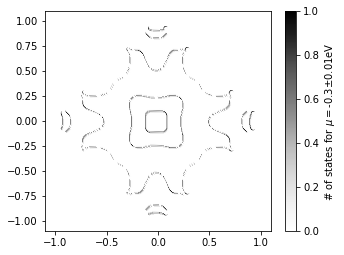

In [55]:
x=[]
y=[]
z=[]
window=0.005
for i in range(N+1):
    for j in range(1,N+2):
        it = (N+1)*i+j-1
        en = ener_mu[it]
        enum = 0
        for l in range(orb):
            if en[l]<window and en[l]>-window:
                enum += 1
#         x.append(k_val1[i])
#         y.append(k_val1[j-1])
#         z.append(enum)
        x.append(kxyz_list[it][0])
        y.append(kxyz_list[it][1])
        z.append(enum)
        
window=0.01
width = 1.5*3.375
height = 0.8*width
fig = plt.figure(1, figsize = [width,height])
ax = fig.add_subplot(111)
#ax.set_xticks([0,0.25,0.5,0.75,1])
#ax.set_xticklabels(['-$\pi$', '-$\pi/2$', 0,'$\pi/2$', '$\pi$'], fontsize=12)
#ax.set_yticks([0,0.25,0.5,0.75,1])
#ax.set_yticklabels(['-$\pi$', '-$\pi/2$', 0,'$\pi/2$', '$\pi$'], fontsize=12)
FS=ax.scatter(x, y, c=z, cmap='Greys', s=10)
fig.colorbar(FS, label='# of states for $\mu=$'+str(xs)+'$\pm$'+str(window)+'eV')
fig.savefig('FS_x='+str(xs)+'_kz='+str(kz)+'_window='+str(window)+'eV.png', dpi=200)
plt.show()

In [227]:
klist_2D1

[[3.141592653589793, -3.141592653589793, -3.141592653589793],
 [3.1101767270538954, -3.1101767270538954, -3.141592653589793],
 [3.078760800517997, -3.078760800517997, -3.141592653589793],
 [3.0473448739820994, -3.0473448739820994, -3.141592653589793],
 [3.015928947446201, -3.015928947446201, -3.141592653589793],
 [2.9845130209103035, -2.9845130209103035, -3.141592653589793],
 [2.9530970943744053, -2.9530970943744053, -3.141592653589793],
 [2.9216811678385075, -2.9216811678385075, -3.141592653589793],
 [2.8902652413026093, -2.8902652413026093, -3.141592653589793],
 [2.8588493147667116, -2.8588493147667116, -3.141592653589793],
 [2.8274333882308134, -2.8274333882308134, -3.141592653589793],
 [2.7960174616949156, -2.7960174616949156, -3.141592653589793],
 [2.7646015351590174, -2.7646015351590174, -3.141592653589793],
 [2.7331856086231205, -2.7331856086231205, -3.141592653589793],
 [2.701769682087222, -2.701769682087222, -3.141592653589793],
 [2.6703537555513246, -2.6703537555513246, -3.14

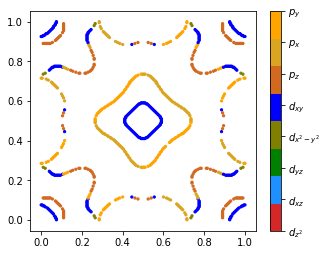

In [226]:
ener_v = energylist[1]

window=0.005
x=[]
y=[]
z=[]
for i in range(N+1):
    for j in range(1,N+2):
        it = (N+1)*i+j-1
        en = ener_mu[it]
        #eigenvectors
        vec_all = np.transpose(ener_v[it])
        vec_abs = np.absolute(vec_all)
    
        for l in range(orb):
            arg = np.argmax(vec_abs[l]) #for orbital content
            if en[l]<window and en[l]>-window:
                if arg==0 or arg==5:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(1)
                elif arg==1 or arg==6:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(2)
                elif arg==2 or arg==7:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(3)
                elif arg==3 or arg==8:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(4)
                elif arg==4 or arg==9:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(5)
                elif arg==10 or arg==13:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(6)
                elif arg==11 or arg==14:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(7)
                elif arg==12 or arg==15:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(8)

fig = plt.figure(1, figsize = [width,height])
ax = fig.add_subplot(111)
# ax.set_xticks([0,0.25,0.5,0.75,1])
# ax.set_xticklabels(['-$\pi$', '-$\pi/2$', 0,'$\pi/2$', '$\pi$'], fontsize=12)
# ax.set_yticks([0,0.25,0.5,0.75,1])
# ax.set_yticklabels(['-$\pi$', '-$\pi/2$', 0,'$\pi/2$', '$\pi$'], fontsize=12)
import  matplotlib.colors
cmap8 = matplotlib.colors.ListedColormap(['tab:red', 'dodgerblue', 'green', 'olive', 'blue', 'chocolate', 'goldenrod', 'orange'])
FS=ax.scatter(x, y, c=z, cmap=cmap8, s=5, vmin=1, vmax=8)
cbar = fig.colorbar(FS, ticks=[1,2,3,4,5,6,7,8])
cbar.ax.set_yticklabels(['$d_{z^2}$','$d_{xz}$','$d_{yz}$','$d_{x^2-y^2}$','$d_{xy}$','$p_{z}$','$p_{x}$','$p_{y}$'])  # vertically oriented colorbar
window=0.01
fig.savefig('FS_all_x='+str(xs)+'_kz='+str(kz)+'_window='+str(window)+'eV.png', dpi=200)
plt.show()

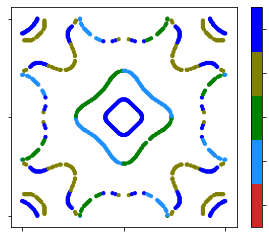

In [229]:
ener_v = energylist[1]
window=0.005

x=[]
y=[]
z=[]
for i in range(N+1):
    for j in range(1,N+2):
        it = (N+1)*i+j-1
        en = ener_mu[it]
        #eigenvectors
        vec_all = np.transpose(ener_v[it])
        vec_abs = np.absolute(vec_all)
    
        for l in range(orb):
            arg = np.argmax(vec_abs[l][0:10]) #for orbital content
            if en[l]<window and en[l]>-window:
                #print(arg, en[l])
                if arg==0 or arg==5:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(1)
                elif arg==1 or arg==6:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(2)
                elif arg==2 or arg==7:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(3)
                elif arg==3 or arg==8:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(4)
                elif arg==4 or arg==9:
                    x.append(k_val1[i])
                    y.append(k_val1[j-1])
                    z.append(5)

fig = plt.figure(1, figsize = [width,height])
ax = fig.add_subplot(111)
import matplotlib
ax.set_xticks([0,0.5,1])
#ax.set_xticklabels(['-$\pi$', '-$\pi/2$', 0,'$\pi/2$', '$\pi$'], fontsize=12)
ax.set_yticks([0,0.5,1])
#ax.set_yticklabels(['-$\pi$', '-$\pi/2$', 0,'$\pi/2$', '$\pi$'], fontsize=12)
ax.set_xticklabels([], fontsize=12)
ax.set_yticklabels([], fontsize=12)
cmap5 = matplotlib.colors.ListedColormap(['tab:red', 'dodgerblue', 'green', 'olive', 'blue'])
FS=ax.scatter(x, y, c=z, cmap=cmap5, s=10, vmin=1, vmax=5)
cbar = fig.colorbar(FS, ticks=[1.4,2.2,3,3.8,4.6])
#cbar.ax.set_yticklabels(['$d_{z^2}$','$d_{xz}$','$d_{yz}$','$d_{x^2-y^2}$','$d_{xy}$','$p_{z}$','$p_{x}$','$p_{y}$'], fontsize='12')  # vertically oriented colorbar
cbar.ax.set_yticklabels([], fontsize='12')  # vertically oriented colorbar
window=0.01
fig.savefig('FS_d_x='+str(xs)+'_kz='+str(kz)+'_window='+str(window)+'eV.png', dpi=200)
plt.show()